In [ ]:
!pip install transformers sentence-transformers datasets rouge_score nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=ccd8e0974e616e8073e2af7eac13cf4e14d217bb3875c490e55f2f28c692a609
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


### Summarization

Ваше задание заполнить пропуски в функциях, улучшить качество модели за счёт более сложного алгоритма отбора предложений, в конце вызвать несколько abstractive summarization моделей и провести анализ результатов по метрикам ROUGE-1,2,L.

In [ ]:
import nltk
import numpy as np
from tqdm import tqdm
from tqdm.auto import trange
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import datasets
data = datasets.load_dataset("multi_news")
train_dataset, val_dataset = data['train'], data['validation']
val_dataset = val_dataset.shuffle(seed=1).select(range(1125))


SEMINAR_MODE = False
if SEMINAR_MODE:
  val_dataset = [val_dataset[i] for i in range(0, len(val_dataset), 5)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
val_dataset = val_dataset.filter(lambda example: len(example["document"]) > 0)

In [ ]:
val_dataset

Dataset({
    features: ['document', 'summary'],
    num_rows: 1125
})

In [ ]:
example = val_dataset[42]
sources = tuple(filter(len, map(str.strip, example['document'].split('|||||'))))

for i, source in enumerate(sources):
    print(f"SOURCE #{i}: {source}\n{'=' * 50}\n")
print("SUMMARY:\n", example['summary'])

SOURCE #0: You’ve got 100,000s of options at your fingertips. Try new things, have more fun and go for it. 
 
 You’ve got 100,000s of options at your fingertips. Try new things, have more fun and go for it.

SOURCE #1: Photo Advertisement Continue reading the main story 
 
 For many women, a $1,000 dress is something they admire in the pages of a glossy magazine or see draped on the frame of a celebrity — not an item hanging in their closet. 
 
 
 
 
 
 
 
 
 
 But a nascent Web site called Rent the Runway is hoping to make high-end fashions much more accessible and almost as easy as renting a movie from Netflix. 
 
 The mail-order service, which finishes the testing phase on Monday, allows women to rent dresses from notable fashion designers like Diane Von Furstenberg, Hervé Léger and Proenza Schouler for roughly one-tenth of what they would cost to buy in a retail store. 
 
 The rentals run $50 to $200 for a four-night loan and are shipped directly to the customer’s doorstep. After w

In [ ]:
MAX_WORDS = 100

def summarize_baseline(doc: str, max_words=MAX_WORDS):
    sentences = nltk.sent_tokenize('\n'.join(doc.split('|||||')))
    summary = []
    num_words = 0

    for sent in sentences:
        sentence_length = len(nltk.word_tokenize(sent))
        if num_words + sentence_length > max_words:
            break
        num_words += sentence_length
        summary.append(sent)
    return ' '.join(summary)

In [ ]:
print(summarize_baseline(val_dataset[42]['document']))

You’ve got 100,000s of options at your fingertips. Try new things, have more fun and go for it. You’ve got 100,000s of options at your fingertips. Try new things, have more fun and go for it. Photo Advertisement Continue reading the main story 
 
 For many women, a $1,000 dress is something they admire in the pages of a glossy magazine or see draped on the frame of a celebrity — not an item hanging in their closet.


### Замерим ROUGE

In [ ]:
from rouge_score import rouge_scorer
from tqdm.auto import trange


scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(target='The quick brown fox jumps over the lazy dog',
                      prediction='The quick brown dog jumps on the log.')
print(scores['rouge1'].fmeasure, scores['rougeL'].fmeasure)

0.7058823529411765 0.5882352941176471


In [ ]:
def compute_rouge_f1(dataset, predictions):
    ############# <YOUR CODE: compute mean f-measures for Rouge-1 and Rouge-L>
    rouge_one_scores = []
    rouge_l_scores = []
    for references, prediction in tqdm(zip(dataset, predictions), total=len(dataset)):
        references = references["summary"]
        scores = scorer.score(references, prediction)
        rouge_one_scores.append(scores['rouge1'].fmeasure)
        rouge_l_scores.append(scores["rougeL"].fmeasure)

    mean_r1 = sum(rouge_one_scores) / len(rouge_one_scores)
    mean_rL = sum(rouge_l_scores) / len(rouge_l_scores)

    return mean_r1, mean_rL

In [ ]:
baseline_predictions = [summarize_baseline(row['document']) for row in val_dataset]
baseline_rouge1, baseline_rougeL = compute_rouge_f1(val_dataset, baseline_predictions)

print("\nRouge-1:", baseline_rouge1)
print("Rouge-L:", baseline_rougeL)

if SEMINAR_MODE:
    assert abs(baseline_rouge1 - 0.26632) < 1e-4 and abs(baseline_rougeL - 0.14617) < 1e-4
    print("Well done!")

100%|██████████| 1125/1125 [00:13<00:00, 83.31it/s]


Rouge-1: 0.26792856680501553
Rouge-L: 0.14620758352127172


### Neural extractive summarization

![](https://i.imgur.com/kkrzeq7.png)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, max_features=50_000)
vectorizer.fit([item['document'] for item in train_dataset])
encode_func = lambda texts: vectorizer.transform(texts).toarray()

In [ ]:
doc = val_dataset[42]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

Sentence embeddings shape: (47, 50000)
Document embedding shape: (2, 50000)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Compute cosine similarities between each pair of sentences
sentence_similarities = cosine_similarity(sentence_embeddings)

# ... and also between each sentence and each document
document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)

assert sentence_similarities.shape == (len(sentences), len(sentences))
assert document_similarities.shape == (len(sentences), len(documents))

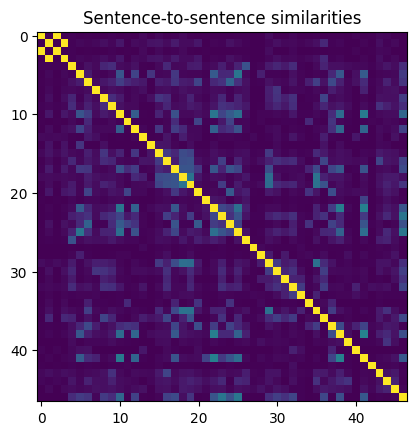

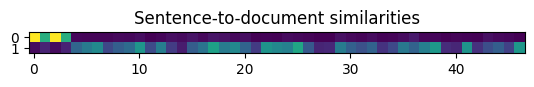

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()

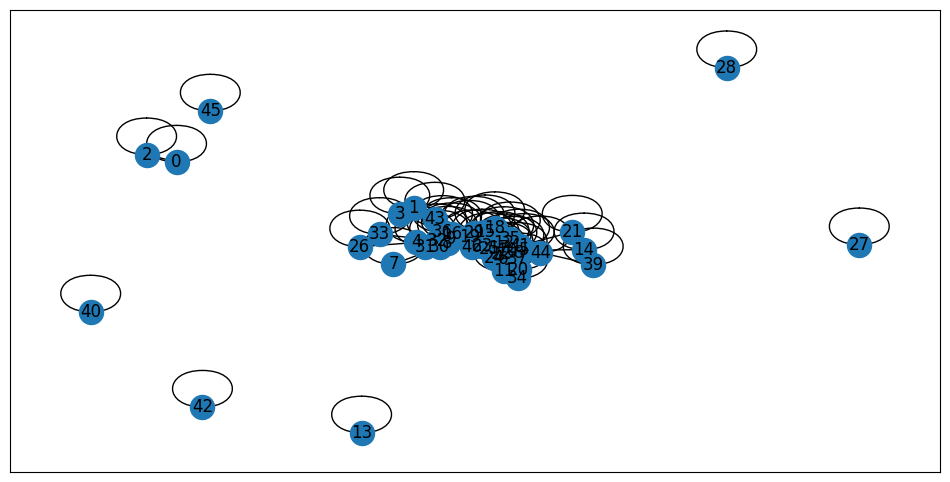

In [ ]:
import networkx

plt.figure(figsize=(12, 6))
networkx.draw_networkx(networkx.from_numpy_array(sentence_similarities > 0.1))

In [ ]:
def choose_summary_greedy(sentences, sentence_scores, sentence_similarities, sentence_lengths,
                          max_words=MAX_WORDS, sim_threshold=0.9):
    assert sentence_scores.shape == (len(sentences),)
    chosen_sentences = []
    max_similarities = np.zeros(len(sentences))
    num_words = 0

    for i in range(len(sentences)):
        mask = (sentence_lengths <= (max_words - num_words)) & (max_similarities < sim_threshold)
        if not np.any(mask):
            break

        best_sentence_index = np.argmax(sentence_scores * mask)

        chosen_sentences.append(sentences[best_sentence_index])


        max_similarities = np.maximum(max_similarities, sentence_similarities[best_sentence_index])
        num_words += sentence_lengths[best_sentence_index]

    return chosen_sentences



In [ ]:
sentence_scores = sentence_similarities.mean(axis=-1)

summary_sentences = choose_summary_greedy(
    sentences, sentence_scores, sentence_similarities, sentence_lengths,
    max_words=MAX_WORDS, sim_threshold=0.7)
print(summary_sentences)

['Rent the Runway is betting that its shop-by-Web convenience and the appeal of its top-quality fashions will persuade women across the country to rent a dress for a special occasion without trying it on beforehand.', '“No one wants to rent last season’s dress.”', 'And instead of just buying one or two dresses for this season, I can still have a lot of things to wear.” \n \n Rent the Runway was founded by two recent Harvard Business School graduates, Jennifer Hyman and Jennifer Carter Fleiss.', '“It was so easy.']


### Putting it all together

In [ ]:
def summarize_one(document, max_words=MAX_WORDS, sim_threshold=0.7):
    documents = tuple(filter(len, map(str.strip, document.split('|||||'))))

    sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
    sentences = [sent for document in sentences_by_doc for sent in document]
    sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

    # use encode_func to compute embedding matrices
    sentence_embeddings = encode_func(sentences)
    document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))

    # compute pairwise similarities between sentences and sentence-document pairs
    sentence_similarities = cosine_similarity(sentence_embeddings)
    document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)


    # Compute the scores s.t. higher score corresponds to better sentences.
    # There are many ways to devise such a function, try them for yourself and see which works best.
    # Here's a few inspirations:
    # - mean similarity to 3 nearest sentences [please start with this one]
    # - page-rank scores that use similarity matrix as connectivity matrix
    # - distance to the nearest cluster in embedding space using k-means clustering
    sentence_scores = np.mean(np.sort(sentence_similarities, axis=1)[:, -3:], axis=1)

    ######## Change for more interesting algo and results
    ######## [make dep inj or clone function to preserve results for comparison]
    summary_sentences = choose_summary_greedy(
        sentences, sentence_scores, sentence_similarities, sentence_lengths,
        max_words=max_words, sim_threshold=sim_threshold)

    return '\n'.join(summary_sentences)

In [ ]:
print(summarize_one(val_dataset[2]['document']))

The "sanity" rally blending laughs... (Associated Press) 
 
 People vie for position during Rally to Restore Sanity and/or Fear in Washington, in Saturday, Oct. 30, 2010.
The "sanity" rally blending laughs and political activism drew thousands to the National Mall... (Associated Press) 
 
 Val Ibarra, 29, of San Francisco, Ca., holds up a sign at the Rally to Restore Sanity and/or Fear in Washington Saturday, Oct. 30, 2010.
Fittingly, Beck held his rally in front of the Lincoln Memorial.


In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("\nRouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

100%|██████████| 1125/1125 [00:15<00:00, 70.67it/s]


Rouge-1: 0.297590583695404
Rouge-L: 0.1591754945553087


### Can we do better than TF-IDF?

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE').train(False)

In [ ]:
emb1, emb2, emb3, emb4 = model.encode(
    ['Hello, world!', 'Greeting, universe!', 'Hello, John!', "A cat sat on the mat."]
)

In [ ]:
print("Sim(hello world, hello john) =", emb1 @ emb3)
print("Sim(hello world, greetings universe) =", emb1 @ emb2)
print("Sim(hello world, a cat sat on the mat)=", emb1 @ emb4)

Sim(hello world, hello john) = 0.7253735
Sim(hello world, greetings universe) = 0.7909731
Sim(hello world, a cat sat on the mat)= 0.16162983


In [ ]:
encode_func = model.encode

Sentence embeddings shape: (70, 768)
Document embedding shape: (3, 768)


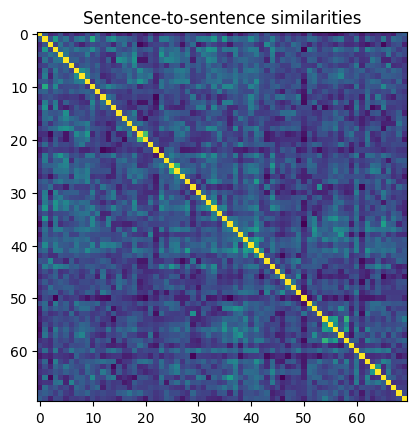

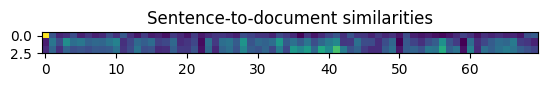

In [ ]:
doc = val_dataset[50]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

sentence_similarities = sentence_embeddings @ sentence_embeddings.T
document_similarities = sentence_embeddings @ document_embeddings.T

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()


In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("\nRouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

100%|██████████| 1125/1125 [00:19<00:00, 58.11it/s]


Rouge-1: 0.30073148790434223
Rouge-L: 0.16034361930392158


In [ ]:
model = SentenceTransformer('sentence-transformers/LaBSE').eval()

In [ ]:
from sklearn.cluster import KMeans

def summarize_one_smart(document, max_words=MAX_WORDS, sim_threshold=0.7):
    documents = tuple(filter(len, map(str.strip, document.split('|||||'))))

    sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
    sentences = [sent for document in sentences_by_doc for sent in document]
    sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

    sentence_embeddings = model.encode(sentences)

    # Cluster sentences based on embeddings
    kmeans = KMeans(n_init="auto", n_clusters=min(len(sentences), len(sentences) // 3 + 1))
    cluster_labels = kmeans.fit_predict(sentence_embeddings)

    # Choose one representative sentence from each cluster
    cluster_representatives = []
    for cluster_id in range(kmeans.n_clusters):
        cluster_sentences = [sentences[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
        if cluster_sentences:
            cluster_representatives.append(max(cluster_sentences, key=len))  # Choose the longest sentence in the cluster

    # Sort representatives based on their position in the document
    sorted_representatives = sorted(cluster_representatives, key=lambda x: sentences.index(x))

    # Limit the summary to max_words
    summary = []
    num_words = 0
    for sentence in sorted_representatives:
        if num_words + len(nltk.word_tokenize(sentence)) <= max_words:
            summary.append(sentence)
            num_words += len(nltk.word_tokenize(sentence))
        else:
            break

    return '\n'.join(summary)

In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one_smart(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("\nRouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

100%|██████████| 1125/1125 [00:12<00:00, 88.99it/s] 


Rouge-1: 0.26768305076115656
Rouge-L: 0.1487358672693305


### Call the cavalry!

[Pegasus](https://arxiv.org/abs/1912.08777) is an *abstractive* summarization model based on a large pre-trained transformer. Before doing any summarizaton, the model is pre-trained on a combination of MLM and a specialized objective called Gap Sentence Generation: predicting an entire sentence omitted from the middle of the text.

Compare with our models and gensim

In [ ]:
import torch

In [ ]:
import transformers
pegasus = transformers.pipeline("summarization", "google/pegasus-multi_news", device=0)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-multi_news and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(pegasus(" ".join(nltk.sent_tokenize(" ".join(val_dataset[i]["document"].split("|||||")))[:30]), min_length=5, max_length=100)[0]['summary_text'])

In [ ]:
document = example['document'].split('|||||')[0]
print("SUMMARY:", pegasus([document], min_length=5, max_length=100)[0]['summary_text'])

Your max_length is set to 100, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


SUMMARY: – If you're looking for the perfect gift for your significant other this holiday season, we've got just the thing for you. We've put together a list of the best holiday gifts you can get for your significant other, based on their age, gender, and what they like to do. If you're looking for something a little more adult, we've got a list of the best adult-themed birthday gifts. And if you're looking for the perfect
